In [54]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [55]:
# 加载数据集
# data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a
X_train_orig,y_train_orig = load_svmlight_file('data/a9a')
X_val_orig, y_val_orig = load_svmlight_file('data/a9a.t', n_features=123)

# 转换为列向量
X_train = X_train_orig.T.toarray()
X_val = X_val_orig.T.toarray()
y_train = np.reshape(y_train_orig,(1,y_train_orig.shape[0]))
y_val = np.reshape(y_val_orig,(1,y_val_orig.shape[0]))
y_train[y_train<0]=0
y_val[y_val<0]=0
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(123, 32561) (123, 16281) (1, 32561) (1, 16281)


In [56]:
# 用零初始化参数
def init_parameters_with_zeros(dim):
    W = np.zeros((dim,1))
    b = 0
    return W,b

In [57]:
# sigmoid 函数
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [58]:
# 前向传播和反向传播
def propagate(W,b,X,Y):
    m = X.shape[1]

    # 前向传播
    A = sigmoid(np.dot(W.T,X)+b)
    # 计算cost
    cost = (np.dot(Y,np.log(A).T)+np.dot((1-Y),np.log(1-A).T))/(-m)
    
    # 反向传播
    dW = np.dot(X,(A-Y).T)/m  
    db = np.sum(A-Y)/m
    
    cost = np.squeeze(cost)
    return cost,dW,db

In [59]:
def predict(W,b,X):
    m = X.shape[1]
    A = sigmoid(np.dot(W.T,X)+b)
    Y_prediction = np.zeros((1,m))
    Y_prediction[A>=0.5]=1
#     Y_prediction[A<0.5]=0
#     print(A)
    return Y_prediction

In [60]:
def random_batches(X,Y,batch_size):
    m = X.shape[1]
    
    batches = []
    
    # 样本随机排列
    permutation = np.random.permutation(m)
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]

    
    num_batches = math.floor(m/batch_size)
    for i in range(num_batches):
        batch_X = shuffled_X[:,i*batch_size:(i+1)*batch_size]
        batch_Y = shuffled_Y[:,i*batch_size:(i+1)*batch_size]
        
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    if m % batch_size != 0:
        batch_X = shuffled_X[:,num_batches*batch_size:m]
        batch_Y = shuffled_Y[:,num_batches*batch_size:m]
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    return batches
    

In [61]:
def model(X_train, Y_train, X_val, Y_val, batch_size = 64, num_epochs = 200, learning_rate = 0.01, optimizer = "GD", print_cost = False,
         decay_rate = 0.9):
    
    
    eps = 1e-8
    
    # for NAG
    beta = 0.9
    
    
    # for RMSProp
    W_cache = 0
    b_cache = 0
    
    # for AdaDelta
    delta_with_W = 0
    delta_with_b = 0
    delta_W = 0
    delta_b = 0
    
    # for Adam
    beta1 = 0.9
    beta2 = 0.999
    vdW = 0
    sdW = 0
    vdb = 0
    sdb = 0
    
    # 保存训练集和验证集上的cost
    train_cost_log = []
    val_cost_log = []
    
    # 初始化参数
    W,b = init_parameters_with_zeros(X_train.shape[0])
    
    
    
    for i in range(num_epochs):
        
        batches = random_batches(X_train, Y_train, batch_size)
        
        # 计算验证集上的cost
        val_cost,_,_= propagate(W,b,X_val,Y_val)
        val_cost_log.append(val_cost)
        
        for batch in batches:
            (X_batch, Y_batch) = batch
            
    
            # 进行前向传播、反向传播，计算cost和梯度
            train_cost, dW, db = propagate(W,b,X_batch,Y_batch)
            

#             Y_train_prediction = predict(W,b,X_train)
#             Y_val_prediction = predict(W,b,X_val)

            # 保存cost
#             train_cost_log.append(train_cost)
#             val_cost_log.append(val_cost)

            # 更新参数
            if optimizer is "GD": # Gradient Descent
                W = W-learning_rate*dW
                b = b-learning_rate*db
            elif optimizer is "NAG": # Nesterov Accelerated Gradient
#                 x_ahead = x + mu * v
#                 # evaluate dx_ahead (the gradient at x_ahead instead of at x)
#                 v = mu * v - learning_rate * dx_ahead
#                 x += v
                
#                 _,dW,_ =propagate(W+beta*vdW,b,X_batch,Y_batch)
                vdW = beta * vdW + learning_rate * dW
                W = W - vdW
                
#                 _,_,db =propagate(W,b + beta*vdb,X_batch,Y_batch)
                vb = beta * vdb + learning_rate * db
                b = b - vdb
                
                
#                 vdW_prev = vdW
#                 vdW = beta * vdW - learning_rate * dW
#                 W = W - beta * vdW_prev + (1+beta) * vdW
#                 vdb_prev = vdb
#                 vdb = beta * vdb - learning_rate * db
#                 b = b - beta * vdb_prev + (1+beta) * vdb

    #             v_prev = v # back this up
    #             v = mu * v - learning_rate * dx # velocity update stays the same
    #             x += -mu * v_prev + (1 + mu) * v # position update changes form

                
            elif optimizer is "RMSProp": # RMSProp
                W_cache = decay_rate * W_cache + (1 - decay_rate) * dW**2
                W = W - learning_rate * dW / (np.sqrt(W_cache) + eps)
                b_cache = decay_rate * b_cache + (1 - decay_rate) * db**2
                b = b - learning_rate * db / (np.sqrt(b_cache) + eps)

            elif optimizer is "AdaDelta": # AdaDelta
                W_cache = beta * W_cache + (1-beta) * dW**2
                delta_W =  - np.sqrt(delta_with_W + eps)/np.sqrt(W_cache+eps) * dW
                W = W + delta_W
                delta_with_W = beta * delta_with_W + (1-beta)* delta_W ** 2
                
                b_cache = beta * b_cache + (1-beta) * db**2
                delta_b =  - np.sqrt(delta_with_b + eps)/np.sqrt(b_cache+eps) * db
                b = b + delta_b
                delta_with_b = beta * delta_with_b + (1-beta)* delta_b ** 2
                
            elif optimizer is "Adam": # Adam
                vdW = beta1*vdW + (1-beta1)*dW
                sdW = beta2*sdW + (1-beta2)*(dW**2)
                W = W - learning_rate * vdW / (np.sqrt(sdW) + eps)
                vdb = beta1*vdb + (1-beta1)*db
                sdb = beta2*sdb + (1-beta2)*(db**2)
                b = b - learning_rate * vdb / (np.sqrt(sdb) + eps)

        
        if print_cost and i % 100 == 0:
            print ("After epoch %i, train cost: %f" %(i, train_cost))

    
    return W,b,train_cost_log,val_cost_log

![x](https://blog.slinuxer.com/wp-content/ql-cache/quicklatex.com-7d545539b0c4840b7c594b98c9233186_l3.svg)

In [62]:
_,_,_,NAG_loss = model(X_train,y_train,X_val,y_val,num_epochs = 50,batch_size=1024 ,learning_rate = 0.001,optimizer = 'NAG',print_cost=True)
_,_,_,RMSProp_loss = model(X_train,y_train,X_val,y_val,num_epochs = 50,batch_size=1024 ,learning_rate = 0.001,optimizer = 'RMSProp',print_cost=True)
_,_,_,AdaDelta_loss = model(X_train,y_train,X_val,y_val,num_epochs = 50,batch_size=1024 ,learning_rate = 0.001,optimizer = 'AdaDelta',print_cost=True)
_,_,_,Adam_loss = model(X_train,y_train,X_val,y_val,num_epochs = 50,batch_size=1024 ,learning_rate = 0.001,optimizer = 'Adam',print_cost=True)
_,_,_,GD_loss = model(X_train,y_train,X_val,y_val,num_epochs = 100,batch_size=1024 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)

After epoch 0, train cost: 0.618133
After epoch 0, train cost: 0.575617
After epoch 0, train cost: 0.651097
After epoch 0, train cost: 0.435195
After epoch 0, train cost: 0.591421


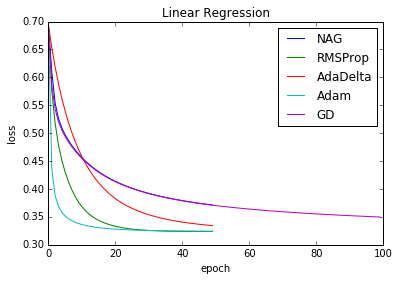

In [63]:
# 画图

plt.plot(NAG_loss, label='NAG')
plt.plot(RMSProp_loss, label='RMSProp')
plt.plot(AdaDelta_loss, label='AdaDelta')
plt.plot(Adam_loss, label='Adam')

plt.plot(GD_loss, label='GD')
# plt.plot(val_loss_log,'b', label = 'validation set')


plt.legend() # 图例
# plt.axis([0,100,0,610])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Linear Regression')
plt.show()